# アストロスケールホールディンク 日足

In [2]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [9]:
pattern = re.compile(r'(.+)\.T')

symbol = '186A.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-18 00:00:00+09:00,1002.0,1039.0,946.0,965.0,2203400,0.0,0.0
2024-09-19 00:00:00+09:00,974.0,1072.0,971.0,1041.0,3678600,0.0,0.0
2024-09-20 00:00:00+09:00,1040.0,1060.0,1014.0,1032.0,1666700,0.0,0.0
2024-09-24 00:00:00+09:00,1060.0,1141.0,1049.0,1120.0,5496300,0.0,0.0
2024-09-25 00:00:00+09:00,1122.0,1180.0,1085.0,1092.0,2864600,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-12 00:00:00+09:00,705.0,789.0,688.0,789.0,10137700,0.0,0.0
2025-03-13 00:00:00+09:00,788.0,824.0,779.0,806.0,10538000,0.0,0.0
2025-03-14 00:00:00+09:00,806.0,823.0,770.0,821.0,6377100,0.0,0.0


In [10]:
df0 = ticker.history(period='max', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-06-05 00:00:00+09:00,1281.0,1581.0,1280.0,1375.0,42052600,0.0,0.0
2024-06-06 00:00:00+09:00,1400.0,1445.0,1088.0,1101.0,34777900,0.0,0.0
2024-06-07 00:00:00+09:00,1145.0,1146.0,976.0,1009.0,23080000,0.0,0.0
2024-06-10 00:00:00+09:00,1030.0,1250.0,1027.0,1246.0,28126600,0.0,0.0
2024-06-11 00:00:00+09:00,1259.0,1287.0,1167.0,1201.0,18227600,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-12 00:00:00+09:00,705.0,789.0,688.0,789.0,10137700,0.0,0.0
2025-03-13 00:00:00+09:00,788.0,824.0,779.0,806.0,10538000,0.0,0.0
2025-03-14 00:00:00+09:00,806.0,823.0,770.0,821.0,6377100,0.0,0.0


## 日足チャートとパラボリック SAR

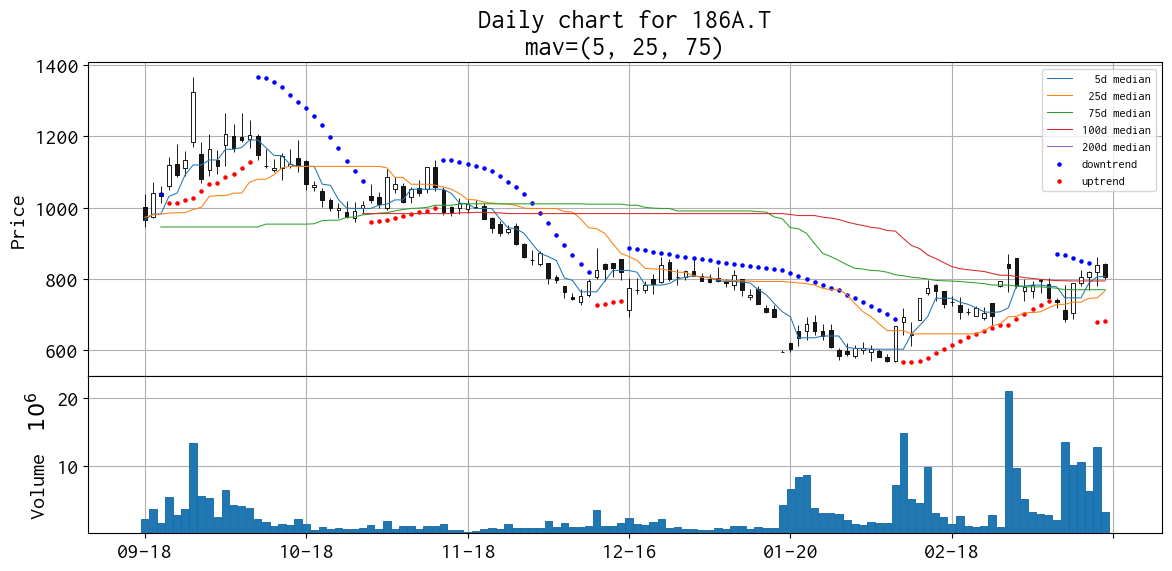

In [11]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.size"] = 16

fig = plt.figure(figsize=(12, 6))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=ax[1],
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [12]:
df.tail(2)['Close']

Date
2025-03-17 00:00:00+09:00    840.0
2025-03-18 00:00:00+09:00    807.0
Name: Close, dtype: float64

In [13]:
df.tail(2)['Close'].diff()

Date
2025-03-17 00:00:00+09:00     NaN
2025-03-18 00:00:00+09:00   -33.0
Name: Close, dtype: float64

In [14]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-03-17 00:00:00+09:00    789.0
2025-03-18 00:00:00+09:00    812.6
Name: Close, dtype: float64

In [15]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-03-17 00:00:00+09:00    752.76
2025-03-18 00:00:00+09:00    757.28
Name: Close, dtype: float64

In [16]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-03-17 00:00:00+09:00    748.986667
2025-03-18 00:00:00+09:00    747.373333
Name: Close, dtype: float64